In [1]:
#Necessary Library
#David
# Edit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
from tensorflow import keras
import os #accessing directory structure

In [2]:
#Load Dataset
def loadData(fileLocation):
    df = pd.read_csv(fileLocation, delimiter = ',')
    df.columns=['Date','Open','High','Low','Close','Volumn','OpenInt']
    df.drop('OpenInt', axis='columns', inplace=True)
    newdf=df[['Date','Open','High','Low','Volumn','Close']]
    return newdf

In [3]:
#Cleaning Up Dataset
from sklearn.preprocessing import MinMaxScaler
def cleanData(df):
    data_value=df.values
    scaler=MinMaxScaler(feature_range=(0,1))
    data_scaled=scaler.fit_transform(data_value)
    data_reframed=seriesToSupervised(data_scaled)
    return data_reframed

In [4]:
def seriesToSupervised(df, nIn=1,nOut=1,dropNan=True):
    nVars=1 if type(df) is list else df.shape[1]
    df=pd.DataFrame(df)
    cols, names=list(),list()
    for i in range(nIn, 0, -1):
        cols.append(df.shift(-i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(nVars)]
    for i in range(0, nOut):
        cols.append(df.shift(-i))
        if(i==0):
            names+=[('var%d(t)' % (j+1)) for j in range(nVars)]
        else:
            names+=[('var%d(t+%d)' % (j+1)) for j in range(nVars)]
        data=pd.concat(cols, axis=1)
        data.columns=names
        if dropNan:
            data.dropna(inplace=True)
        return data


In [5]:
#Split Dataset into Training and Validation Data
def splitData(df):
 
    #x_train, x_test_val, y_train, y_test_val=train_test_split(x,y,random_state=50, test_size=0.3)
    # x_test, x_val, y_test, y_val= train_test_split(x_test_val, y_test_val, test_size=50)
    # print(x_train.shape, y_train.shape)
    num=int(df.shape[0]*0.7)
    value=df.values
    train=value[:num,:]
    test=value[num:,:]
    
    x_train, y_train=train[:,:-1], train[:,-1]
    x_test, y_test=test[:,:-1], test[:,-1]
    
    x_train=x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test= x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

In [6]:
#Open dataset
df=loadData("Data/ETFs/aadr.us.txt")
df.head()

,Date,Open,High,Low,Volumn,Close
0,2010-07-21,24.333,24.333,23.946,43321,23.946
1,2010-07-22,24.644,24.644,24.362,18031,24.487
2,2010-07-23,24.759,24.759,24.314,8897,24.507
3,2010-07-26,24.624,24.624,24.449,19443,24.595
4,2010-07-27,24.477,24.517,24.431,8456,24.517


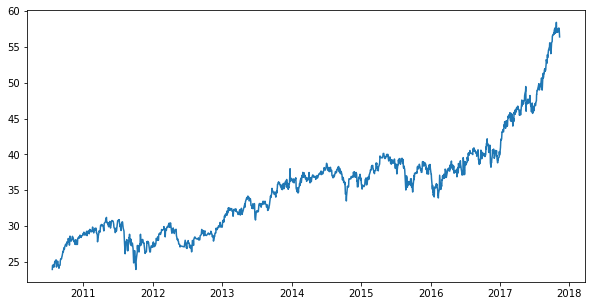

In [7]:
df['Date']=pd.to_datetime(df.Date,format="%Y-%m-%d")
df=df.set_index('Date')
plt.figure(figsize=(10,5))
plt.plot(df["Close"], label="Close Price History")

In [8]:
df=cleanData(df)

In [9]:
df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
0,0.020413,0.020072,0.014631,0.169865,0.015688,0.011446,0.011129,0.002335,0.408142,0.000000
1,0.023729,0.023380,0.013212,0.083807,0.016268,0.020413,0.020072,0.014631,0.169865,0.015688
2,0.019836,0.019497,0.017202,0.183169,0.018820,0.023729,0.023380,0.013212,0.083807,0.016268
3,0.015598,0.016420,0.016670,0.079652,0.016558,0.019836,0.019497,0.017202,0.183169,0.018820
4,0.015598,0.016420,0.014335,0.046779,0.014064,0.015598,0.016420,0.016670,0.079652,0.016558


In [10]:
x_train, y_train, x_test, y_test=splitData(df)

(1094, 1, 9) (470, 1, 9)
(1094,) (470,)


In [11]:
x_train[0]

array([[0.02041287, 0.02007247, 0.01463069, 0.16986536, 0.01568844,
        0.0114462 , 0.011129  , 0.002335  , 0.40814231]])

In [13]:
#for dirName, _, fileNames in os.walk('Data'):
 #   for fileName in fileNames:
  #      dataset+=os.path.join(dirName,fileName)

In [14]:
#Algorithm
#Paula, John, Litepup

#LSTM Model
def createLSTM():
    model=Sequential()
    model.add(LSTM(120, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
   # model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'] )
    return model

In [15]:
modelLSTM=createLSTM()
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 120)            62400     
                                                                 
 dropout (Dropout)           (None, 1, 120)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            88400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 181,051
Trainable params: 181,051
Non-trai

In [16]:
cp_filePath='./checkpoints/'
cp=keras.callbacks.ModelCheckpoint(filepath=cp_filePath,save_weights_only=True)
modelLSTM.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test), callbacks=[cp])
modelLSTM.load_weights(cp_filePath)

Epoch 1/15
35/35 [==============================] - 8s 50ms/step - loss: 0.0416 - accuracy: 0.0018 - val_loss: 0.0415 - val_accuracy: 0.0021
Epoch 2/15
35/35 [==============================] - 0s 9ms/step - loss: 0.0174 - accuracy: 0.0018 - val_loss: 0.0753 - val_accuracy: 0.0000e+00
Epoch 3/15
35/35 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.0018 - val_loss: 0.0922 - val_accuracy: 0.0000e+00
Epoch 4/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0165 - accuracy: 0.0018 - val_loss: 0.1005 - val_accuracy: 0.0000e+00
Epoch 5/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.0018 - val_loss: 0.1003 - val_accuracy: 0.0000e+00
Epoch 6/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0163 - accuracy: 0.0018 - val_loss: 0.1192 - val_accuracy: 0.0000e+00
Epoch 7/15
35/35 [==============================] - 0s 8ms/step - loss: 0.0163 - accuracy: 0.0018 - val_loss: 0.1080 - val_accuracy: 0.0000

In [17]:
modelLSTM.evaluate(x_test,y_test)

15/15 [==============================] - 0s 7ms/step - loss: 0.1172 - accuracy: 0.0000e+00


[0.11718803644180298, 0.0]

In [18]:
y_predict=modelLSTM.predict(x_test)

In [19]:
y_predict=y_predict.reshape((470,1))

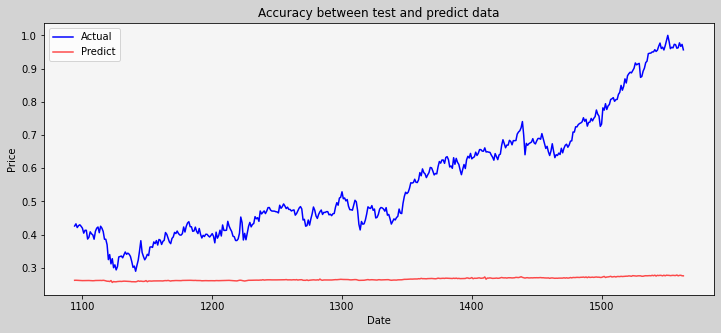

In [20]:
plt.figure(figsize=(12,5), facecolor='lightgrey')
ax = plt.axes()
ax.set_facecolor('whitesmoke')
plt.plot(df.index[-470:], y_test, color='blue',label='Actual')
plt.plot(df.index[-470:], y_predict, alpha=0.7, color='red',label='Predict')
plt.title('Accuracy between test and predict data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()